In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile
data_dir='/content/drive/MyDrive/refcocog.tar.gz'
# Extract data
tar = tarfile.open(data_dir)
tar.extractall()

In [ ]:
pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_jeknnib
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_jeknnib
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=45f6a4a70a076c7c675a798c8d1bb99afbefa680fd4e63145d4661df51d8b5a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-mkzffofr/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
!pip install transformers

In [ ]:
import os, json, pickle, torch, torchvision, io, clip
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, BatchSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

image = preprocess(Image.open()).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 142MiB/s]


In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [ ]:
class RefCOCOgDataset(Dataset):
  def __init__(self, data_dir = 'refcocog', transform = None):
    super(RefCOCOgDataset, self).__init__()
    self.images = []
    self.img_dir = 'refcocog/images/'
    self.descriptions = []
    self.transform = transform
    self.data = {}
    f = open(f'{data_dir}/annotations/refs(umd).p', 'rb')
    self.data = pickle.load(f)
    instances_file = os.path.join(f'{data_dir}/annotations/instances.json')
    instances = json.load(open(instances_file, 'r'))
    self.insta = instances
    print(self.data[0])
    # print(instances.keys())
    for item in self.data:
      self.descriptions.append(item['sentences'])
      img_id = item['image_id']
      for img in instances['images']:
        if img['id'] == img_id:
          self.images.append(img['file_name'])
          break

  def __getitem__(self, idx):
    self.images[idx]
    self.descriptions[idx]
    img_path = os.path.join(self.img_dir, self.images[idx])
    image = Image.open(img_path)

    # label = clip.tokenize("Photo of " +self.descriptions[idx][0]['raw']).flatten()
    if self.transform:
        image = self.transform(image)
    return image, label

  def __len__(self):
    return len(self.images)
  

In [ ]:
full_data_cifer = torchvision.datasets.CIFAR100('./data', train=True, transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 29635636.24it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
print(full_data_cifer[0])

AttributeError: ignored

In [ ]:
from PIL import Image
dataloader = RefCOCOgDataset('refcocog', preprocess)

{'image_id': 380440, 'split': 'test', 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'raw': 'the man in yellow coat', 'sent_id': 8, 'sent': 'the man in yellow coat'}, {'tokens': ['skiier', 'in', 'red', 'pants'], 'raw': 'Skiier in red pants.', 'sent_id': 9, 'sent': 'skiier in red pants'}], 'file_name': 'COCO_train2014_000000380440_491042.jpg', 'category_id': 1, 'ann_id': 491042, 'sent_ids': [8, 9], 'ref_id': 0}


In [ ]:
dataloader.insta.keys()
dataloader.insta['annotations'][0]

In [ ]:
image, desc = dataloader[0]
image1, desc1 = dataloader[1]
# image.shape
print(desc)

tensor([49406,  1125,   539,   518,   786,   530,  4481,  7356, 49407,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], dtype=torch.int32)


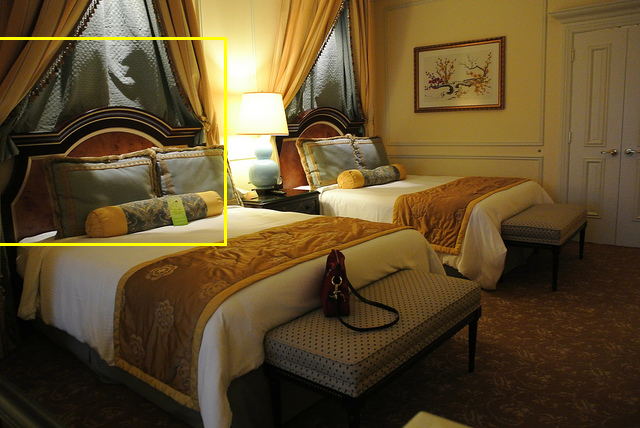

In [ ]:
w = dataloader.insta['annotations'][0]
# print(w['bbox'])
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import functional as F
import PIL.Image

# visualise_result(Image.open("refcocog/images/"+dataloader.insta['images'][0]['file_name']), "habu sabu")
img = Image.open("refcocog/images/"+dataloader.insta['images'][0]['file_name'])
# img.show()

if isinstance(img, PIL.Image.Image):
    image = F.to_image_tensor(img)
image = F.convert_dtype(image, torch.uint8)
boxs = torch.tensor(w['bbox'], dtype=torch.int).to(device) 
boxes = boxs.reshape([1,4])
boxes = torchvision.ops.box_convert(boxes, "cxcywh", "xyxy").to(device)
annotated_image = draw_bounding_boxes(image, boxes, colors="yellow", width=3)

img = torchvision.transforms.ToPILImage()(annotated_image)
img.show()


In [ ]:
def encode_data(images_fp: list[str], texts: list[str]):
  # preprocess the images to transform from filenames to images to tensors
  images = [preprocess(Image.open(r'refcocog/images/'+image)) for image in images_fp]

  # preprocess the texts to transform from text to tensors
  images = torch.tensor(np.stack(images)).to(device)
  text_tokens = clip.tokenize(["Photo of " + desc for desc in texts]).to(device)

  # encode the inputs
  with torch.no_grad():
    images_z = model.encode_image(images).float().to(device)
    texts_z = model.encode_text(text_tokens).float().to(device)
  
  return images_z, texts_z

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-16 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 


requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 428x640 1 handbag, 2 beds
Speed: 12.0ms pre-process, 281.2ms inference, 1.4ms NMS per image at shape (1, 3, 448, 640)
Saved 1 image to runs/detect/exp3


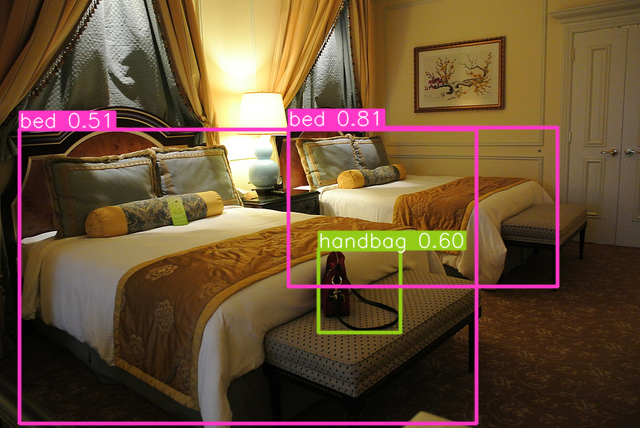

,xmin,ymin,xmax,ymax,confidence,class,name
0,288.968964,127.100830,557.273315,286.947144,0.808232,59,bed
1,318.245117,249.163605,400.886963,332.597382,0.599790,26,handbag
2,19.502319,129.520264,476.208954,423.893616,0.510607,59,bed


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ["refcocog/images/"+dataloader.insta['images'][0]['file_name']]  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()
results.show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]

In [ ]:
texts = []
images = []
j = 0
for i in dataloader:
  j+=1
  img, txt = i
  texts.append(txt)
  images.append(img)
  if j == 20:
    break
imgs = []

for i in images:
  # print(i)
  imgs.append(preprocess(Image.open(r'refcocog/images/'+i)))
# preprocess the texts to transform from text to tensors
imgs = torch.tensor(np.stack(imgs)).to(device)
text_tokens = clip.tokenize(["Photo of " + desc[0]['raw'] for desc in texts]).to(device)

# encode the inputs
with torch.no_grad():
  images_z = model.encode_image(imgs).float().to(device)
  texts_z = model.encode_text(text_tokens).float().to(device)


In [ ]:
full_data = (images_z, texts_z)

In [ ]:
def get_data(batch_size=128, test_batch_size=256):
  # convert the PIL images to Tensors
  full_training_data = dataloader
  num_samples = len(full_training_data)
  training_samples = int(num_samples * 0.5 + 1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False, num_workers=2) 
  return train_loader, val_loader

In [ ]:
data = get_data()

In [ ]:
print(data)

(<torch.utils.data.dataloader.DataLoader object at 0x7f9d829f41f0>, <torch.utils.data.dataloader.DataLoader object at 0x7f9d829f4b50>)


In [ ]:
class CustomCLIP(torch.nn.Module):
  def __init__(self, num_classes: int = 10):
    super().__init__()
    model, _ = clip.load("RN50")
    self.encoder = model.visual.float()
    self.classifier = torch.nn.Linear(1024, num_classes)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.classifier(x)

    return x

In [ ]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [ ]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD([
      {'params': model.classifier.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)
  
  return optimizer

In [ ]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to training mode
  net.train()

  # iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
    print(targets)
    # forward pass
    outputs = net(inputs)

    # loss computation
    loss = cost_function(outputs, targets)

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

def test_step(net, data_loader, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to evaluation mode
  net.eval()

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # load data into GPU
      inputs = inputs.to(device)
    #   targets = targets.to(device)
      targets = targets[0].to(device)
      print(targets)
      # forward pass
      outputs = net(inputs)

      # loss computation
      loss = cost_function(outputs, targets)

      # fetch prediction and loss value
      samples += inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

In [ ]:
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [ ]:
def main(batch_size=128, 
         learning_rate=0.001, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50, 
         num_classes=65):
  writer = SummaryWriter(log_dir="runs/exp1")
  modified_model = CustomCLIP(num_classes=num_classes).to(device)
  train_loader, val_loader = data

  # test_labels = torch.tensor([item[2] for item in test_dataset])
  # test_sampler = BalancedBatchSampler(test_labels, BATCH_SIZE, 1)
  # test_dataloader = DataLoader(test_dataset, batch_sampler=test_sampler)
  optimizer = get_optimizer(modified_model, learning_rate, weight_decay, momentum)
  
  # define the cost function
  cost_function = get_cost_function()
  print('Before training:')
  train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
  # val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
  # test_loss, test_accuracy = test_step(modified_model, val_loader, cost_function)

  # log to TensorBoard
  log_values(writer, -1, train_loss, train_accuracy, "train")
  # log_values(writer, -1, val_loss, val_accuracy, "validation")
  # log_values(writer, -1, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  # print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  # print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # for each epoch, train the network and then compute evaluation results
  for e in range(epochs):
    
    train_loss, train_accuracy = training_step(modified_model, train_loader, optimizer, cost_function)
    # val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)

    # logs to TensorBoard
    # log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    # print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

    # compute final evaluation results
    print('After training:')
    train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
    # val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
    # test_loss, test_accuracy = test_step(modified_model, val_loader, cost_function)

    # log to TensorBoard
    log_values(writer, epochs, train_loss, train_accuracy, "train")
    # log_values(writer, epochs, val_loss, val_accuracy, "validation")
    # log_values(writer, epochs, test_loss, test_accuracy, "test")

    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    # print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    # print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

In [ ]:
main()

Before training:
tensor([49406,  1125,   539,   550, 15455,  2308,  3309,  7242,   840,  5050,
          320,  8786,  4919,  1136,   269, 49407,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)


ValueError: ignored